# includes

In [1]:
from PIL import Image
import os
import numpy as np 
import pandas as pd 
import torchvision.transforms as transforms
from torchvision.models import resnet50
import random
import torch
import matplotlib.pyplot as plt 
import cv2
from scipy.signal import find_peaks , savgol_filter
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from skimage import  exposure
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, cdist


# classes and fonctions

In [59]:


def extract_number(folder_name):
    return int(folder_name.split('.')[0])

def extract_number_files(folder_name):
    return int(folder_name.split('EX')[1].split('.')[0])

def get_images_path_list(input_folder) :
    path_list = []
    parent_folder_path = input_folder
    folders = [f for f in os.listdir(parent_folder_path) if os.path.isdir(os.path.join(parent_folder_path, f))]
    sorted_folders = sorted(folders, key=extract_number)

    for dirs in sorted_folders:
        files = os.listdir(parent_folder_path+dirs)
        file_names = [f for f in files if os.path.isfile(os.path.join(parent_folder_path+dirs, f))]
        file_names = sorted(file_names, key=extract_number_files)
        # print(dirs)
        for filename in file_names:
            image_path = os.path.join(parent_folder_path+dirs, filename)
            # print(image_path)
            path_list.append(image_path)

    return path_list


def apply_pca(data,name, n_components=2):

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)

    pca_columns = [f'PC_{name}_{i+1}' for i in range(principal_components.shape[1])] # for i in range(n_components)

    return pd.DataFrame(data=principal_components, columns=pca_columns)

def calculate_dunn_index(data, labels):
    clusters = np.unique(labels)
    intra_cluster_distances = []
    inter_cluster_distances = []
    
    for cluster in clusters:
        cluster_points = data[labels == cluster]
        if len(cluster_points) > 1:
            intra_cluster_distance = np.max(pdist(cluster_points))
        else:
            intra_cluster_distance = 0
        intra_cluster_distances.append(intra_cluster_distance)
    
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            cluster_i_points = data[labels == clusters[i]]
            cluster_j_points = data[labels == clusters[j]]
            inter_cluster_distance = np.min(cdist(cluster_i_points, cluster_j_points))
            inter_cluster_distances.append(inter_cluster_distance)
    
    dunn_index = np.min(inter_cluster_distances) / np.max(intra_cluster_distances)
    return dunn_index

def plot_hog_example(image):
    fd, hog_image = hog(image, orientations=8 , pixels_per_cell=(16, 16) ,cells_per_block=(1, 1),
                    visualize=True, channel_axis=-1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Input image')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()


def plot_five_ex_clusters(clusters , images):

    # 5. Filter out noise and small clusters
    unique_clusters = np.unique(clusters)
    filtered_clusters = [cluster for cluster in unique_clusters if cluster != -1]

    # 6. Select representative images from each cluster
    n_examples = 5
    example_images = {cluster: [] for cluster in filtered_clusters}

    for cluster in filtered_clusters:
        cluster_indices = np.where(clusters == cluster)[0]
        if len(cluster_indices) > 10:  # Minimum cluster size threshold
            selected_indices = random.sample(list(cluster_indices), min(n_examples, len(cluster_indices)))
            example_images[cluster] = selected_indices

    # 7. Plot example images from each cluster
    plt.figure(figsize=(15, len(example_images) * 3))
    for i, (cluster, indices) in enumerate(example_images.items()):
        for j, index in enumerate(indices):
            plt.subplot(len(example_images), n_examples, i * n_examples + j + 1)
            plt.imshow(images[index], cmap=plt.cm.gray)
            plt.axis('off')
            if j == 0:
                plt.title(f'Cluster {cluster}')
    plt.tight_layout()
    plt.show()

def Calculate_avg_leaf_to_background_ratio(binary_images):

    black_pixels = np.sum(binary_images == 0)
    white_pixels = np.sum(binary_images == 255)
    average_leaf_to_background_ratio = white_pixels /  black_pixels if black_pixels != 0 else float('nan')
    return average_leaf_to_background_ratio

def find_Length_and_width(image_array):
    y_start = 0
    x_start = 0
    y_end , x_end = image_array.shape
    
    # find y_start , y_end
    for i in range(image_array.shape[0]): 
        if (image_array[i].sum() > 0) and (y_start == 0):
            y_start = i

        if (image_array[-i].sum()>0) and (y_end == image_array.shape[0]):
            y_end = image_array.shape[0] - i
    # find x_start , x_end
    for j in range(image_array.shape[1]): 
        if (image_array[: , j].sum() > 0) and (x_start == 0):
            x_start = j
        if (image_array[: , -j].sum() > 0) and (x_end == image_array.shape[1]):
            x_end = image_array.shape[1] - j

    return y_start , y_end , x_start , x_end

    
def plot_image_and_distances(binary_images , distances):
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(binary_images, cv2.COLOR_BGR2RGB))
    # plt.plot([centroid_x], [centroid_y], marker='o', markersize=5, color="red")
    plt.title("Leaf Image")


    plt.subplot(2, 2, 2)
    plt.plot(distances)
    plt.title("Distances of Contour Points from Centroid")
    plt.xlabel("Contour Point Index")
    plt.ylabel("Distance from Centroid")

    plt.show()
        
class Images_class():
    def __init__(self) -> None:
        self.cnn_model = resnet50(pretrained=True)
        self.rgb_images = []
        self.gray_images = []
        self.binary_images = []
        self.contours_images=[]
        self.list_distances=[]
        self.pil_images = []
        self.cnn_feature = np.array([])
        self.list_images_hog= np.array([])

    def get_images_inf(self , input_folder ):
        path_list = get_images_path_list(input_folder )
        for image_path in path_list:
                
            image = cv2.imread(image_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            cnt = tuple()
            for i in range(len(contours)):
                if len(cnt) < len(contours[i]):
                    cnt = contours[i]

            img = Image.open(image_path).convert('RGB')
            # img = img.resize(target_size)

            self.pil_images.append(img)
            self.rgb_images.append(image)
            self.gray_images.append(gray)
            self.binary_images.append(thresholded)
            self.contours_images.append(cnt)

    def extract_cnn_features(self, target_size:tuple=(192,144)):

        model = self.cnn_model.eval()  
        
        preprocess = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),
        ])

        features = []
        for img in self.pil_images:
            img_tensor = preprocess(img).unsqueeze(0)
            with torch.no_grad():
                feature = model(img_tensor).squeeze().numpy()
            features.append(feature)

        self.cnn_feature = np.array(features)

    def Calculate_distance_each_contour_from_centroid(self):
        for cnt in self.contours_images:
            M = cv2.moments(cnt)
            centroid_x = int(M['m10'] / M['m00'])
            centroid_y = int(M['m01'] / M['m00'])

            distances = []
            for point in cnt:
                x, y = point[0]
                distance = np.sqrt((x - centroid_x) ** 2 + (y - centroid_y) ** 2)
                distances.append(distance)

            distances = np.array(distances)
            distances = distances / np.max(distances)

            self.list_distances.append(list(distances))

    
    def get_pictures_hog(self):
        hog_list = []
        for image in self.rgb_images:
            fd , hog_image = hog(image, orientations=8 , pixels_per_cell=(32, 32) ,cells_per_block=(2, 2),visualize=True, channel_axis=-1)
            hog_list.append(fd)

        self.list_images_hog = np.vstack(hog_list)


# leaves_final dir

In [5]:
images = Images_class()
images.get_images_inf('leaves_final/')
images.Calculate_distance_each_contour_from_centroid()

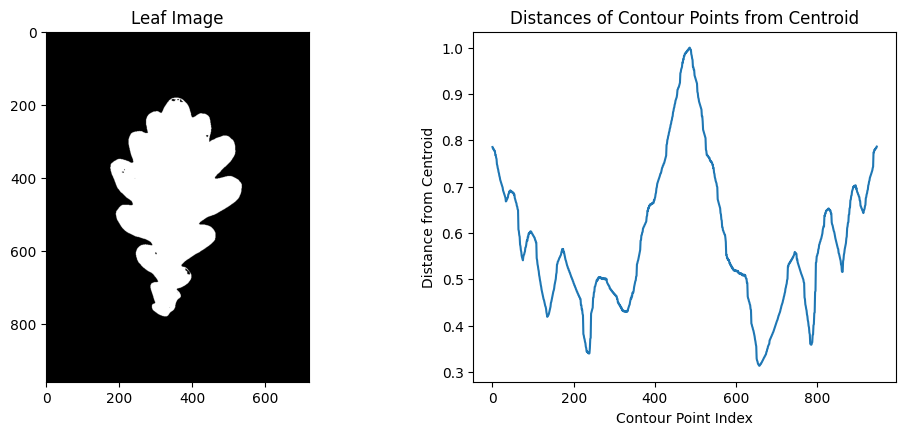

In [38]:
plot_image_and_distances(images.binary_images[50] , images.list_distances[50])

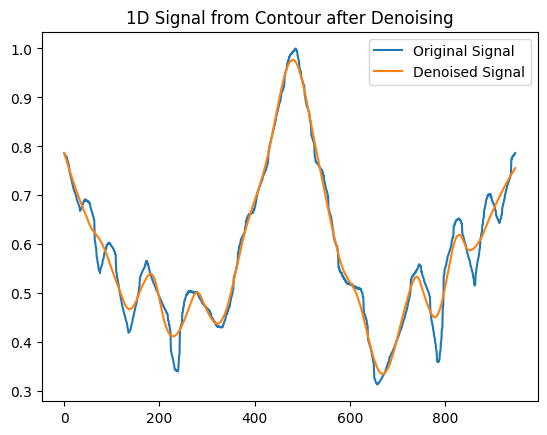

6

In [49]:
from scipy.signal import find_peaks , savgol_filter
def count_petals_of_leaf(distances):

    smoothed_signal = savgol_filter(distances, window_length=100, polyorder=2)
    minima_indices = find_peaks(-smoothed_signal)[0]

    return minima_indices

smoothed_signal = savgol_filter(images.list_distances[50], window_length=100, polyorder=2)
plt.plot(images.list_distances[50], label='Original Signal')
plt.plot(smoothed_signal, label='Denoised Signal')
plt.title('1D Signal from Contour after Denoising')
plt.legend()
plt.show()

len(count_petals_of_leaf(images.list_distances[50]))

### extract some features ('mean_distance' , 'num_petals_of_leaves' , ... )

In [5]:

std_distance_list = []
min_distance_list = []
mean_distance_list = []
num_petals_of_leaves_list = []
legth_to_width_ratio = []
avg_leaf_to_background_list=[]
form_factors_list = []
convexity_list = []
red_mean_color_list = []
green_mean_color_list = []
blue_mean_color_list = []
perimeter_list = []
for i in range(len(images.list_distances)):

    y_start , y_end , x_start , x_end = find_Length_and_width(images.binary_images[i])
    smoothed_signal = savgol_filter(images.list_distances[i], window_length=100, polyorder=2)
    minima_indices = find_peaks(-smoothed_signal)[0]

    num_petals_of_leaves_list.append(len(minima_indices))
    legth_to_width_ratio.append((y_end - y_start) / (x_end - x_start))
    avg_leaf_to_background_list.append(Calculate_avg_leaf_to_background_ratio(images.binary_images[i][y_start:y_end , x_start:x_end]))
    mean_distance_list.append(np.mean(images.list_distances[i]))
    std_distance_list.append(np.std(images.list_distances[i]))
    min_distance_list.append(np.min(images.list_distances[i]))
    

    
    # Calculate shape features
    area = cv2.contourArea(images.contours_images[i])
    perimeter = cv2.arcLength(images.contours_images[i], True)
    convex_hull = cv2.convexHull(images.contours_images[i])
    convexity = perimeter / cv2.arcLength(convex_hull, True)
    form_factor = (4 * np.pi * area) / (perimeter ** 2)

    form_factors_list.append(form_factor)
    convexity_list.append(convexity)
    perimeter_list.append(perimeter)

    # Calculate color features
    mean_color = np.mean(np.array(images.rgb_images[i][y_start:y_end , x_start:x_end]), axis=(0, 1))
    red_mean_color_list.append(mean_color[0])
    green_mean_color_list.append(mean_color[1])
    blue_mean_color_list.append(mean_color[2])



new_features = {
    'mean_distance' : mean_distance_list,
    'std_distance' : std_distance_list,
    'min_distance' : min_distance_list,
    'legth_to_width_ratio' : legth_to_width_ratio,
    'avg_leaf_to_background_ratio' : avg_leaf_to_background_list,
    'num_petals_of_leaves' : num_petals_of_leaves_list ,
    'Perimeter': perimeter_list,
    'Convexity': convexity_list,
    'Form_Factor': form_factors_list,
    'red_mean_color' : red_mean_color_list,
    'green_mean_color' : green_mean_color_list,
    'blue_mean_color' : blue_mean_color_list

    }
new_features= pd.DataFrame(new_features)
new_features

,mean_distance,std_distance,min_distance,legth_to_width_ratio,avg_leaf_to_background_ratio,num_petals_of_leaves,Perimeter,Convexity,Form_Factor,red_mean_color,green_mean_color,blue_mean_color
0,0.703678,0.111736,0.542103,1.631579,2.244901,2,1324.923002,1.122935,0.654050,137.874492,143.570911,150.455605
1,0.704189,0.107399,0.543525,1.654028,2.066886,2,954.205187,1.104718,0.679600,135.351634,142.043754,150.549179
2,0.636708,0.138305,0.465885,1.809816,1.882448,3,779.251868,1.086929,0.643277,129.790995,133.262348,142.879297
3,0.646394,0.119500,0.469862,1.634518,1.938800,2,897.920916,1.106151,0.646818,124.600246,132.707050,136.722010
4,0.627335,0.154731,0.407736,2.000000,1.946505,2,693.269115,1.082260,0.612968,123.963884,126.659919,138.301097
...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.666967,0.147156,0.292140,1.010050,0.956037,11,3844.945639,2.064982,0.149846,178.925034,197.409074,182.028401
336,0.685826,0.135519,0.296964,1.013953,1.088619,16,4631.954859,2.293630,0.128529,170.040649,192.174001,175.060318
337,0.430635,0.128816,0.190799,1.580460,0.501203,13,3931.173991,1.962504,0.116930,203.234973,217.892542,210.571717
338,0.591605,0.204739,0.159810,2.048969,0.406573,7,2848.924214,2.045761,0.135524,200.613402,214.759904,207.218142


### Extract Features using a Pre-trained CNN with PyTorch

In [6]:
images.extract_cnn_features()
images.cnn_feature.shape 

(340, 1000)

#### apply_PCA on cnn_features

In [29]:
pca_df = apply_pca(images.cnn_feature,"cnn_features" , 300)
pca_df

,PC_cnn_features_1,PC_cnn_features_2,PC_cnn_features_3,PC_cnn_features_4,PC_cnn_features_5,PC_cnn_features_6,PC_cnn_features_7,PC_cnn_features_8,PC_cnn_features_9,PC_cnn_features_10,...,PC_cnn_features_291,PC_cnn_features_292,PC_cnn_features_293,PC_cnn_features_294,PC_cnn_features_295,PC_cnn_features_296,PC_cnn_features_297,PC_cnn_features_298,PC_cnn_features_299,PC_cnn_features_300
0,-4.326762,12.688018,-4.027135,-5.670854,-2.086144,2.012494,18.332125,10.178435,1.924265,-12.302287,...,0.033572,-0.010518,-0.034596,-0.014984,0.035256,0.094613,0.032579,-0.013628,0.067790,0.004125
1,5.453883,13.399913,13.139156,-6.451776,-10.047402,-2.767527,11.489892,1.188227,-2.971222,-5.032829,...,0.004453,0.018231,-0.017551,-0.000132,-0.002508,0.016903,-0.046476,0.055098,-0.019882,0.018730
2,6.560716,-2.364224,28.154074,2.840922,-1.239411,-7.368773,12.356169,0.702028,-1.689716,-3.769760,...,-0.047575,0.013938,-0.123098,-0.048571,-0.022147,-0.089696,0.035225,-0.015015,0.013575,0.031177
3,13.066338,-0.425090,16.977499,-5.719292,-3.577883,-5.411007,17.929153,2.548484,-0.287468,-2.565145,...,-0.026613,-0.027977,0.094349,0.104929,0.021374,0.032080,-0.049775,-0.035810,0.024177,-0.058507
4,9.563449,-7.533682,26.966635,-2.891728,3.584435,-7.252154,9.386483,-1.834191,1.592076,-3.837691,...,-0.145137,0.046358,-0.127011,-0.051231,0.014451,-0.056960,0.085369,0.084503,0.087609,0.116989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,39.924114,-1.145427,-8.118554,0.327844,-2.732308,16.542618,-5.077280,-2.962644,5.790912,1.674821,...,0.008762,-0.009915,-0.005118,-0.002496,0.029409,-0.021870,0.037482,-0.166817,0.045872,-0.061018
336,39.661518,2.119118,-12.442564,2.760475,-5.748217,17.055761,-5.394181,-1.945411,5.838661,2.098534,...,0.031144,0.051872,0.038765,-0.025834,-0.034399,0.010401,0.001705,0.079055,-0.005823,0.009993
337,37.205956,-3.596501,-14.829431,-3.200914,-3.984190,12.806565,-6.219615,6.715393,-0.236306,1.585872,...,-0.053962,0.031598,-0.050053,0.018665,0.051784,-0.008672,0.065407,-0.000741,0.014031,0.035614
338,36.426514,-6.320492,2.502547,-5.289193,0.410008,11.398077,-7.701868,-4.496006,1.880338,2.741442,...,-0.043393,-0.071441,-0.077740,-0.002825,0.013344,0.025862,0.043546,0.065383,0.041607,-0.082191


In [ ]:

# optics = OPTICS(min_samples=10  , xi=0.00000001 ,p=2  )
# optics_clusters = optics.fit_predict(pca_df)
# print(set(optics_clusters))
# optics_clusters
n_clusters =16
clustering_model = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_clusters = clustering_model.fit_predict(pca_df)
kmeans_clusters
# dbscan = DBSCAN(eps=4.5, min_samples=10)  # You might need to tune these parameters
# # clusters = dbscan.fit_predict(features_scaled)
# dbscan.fit(pca_df)
# labels = dbscan.labels_
# labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC_cnn_features_1'], pca_df['PC_cnn_features_2'], c=kmeans_clusters, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=[0, 1, 2, 3])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Spectral Clustering of Leaves (k=4)')
plt.show()

In [9]:
# new_features['cnn_Kmeans_8_cluster']= kmeans_clusters
# new_features['optics_cluster_cnnfeatures']= optics_clusters
new_features = pd.concat([new_features , pd.DataFrame(images.cnn_feature)], axis=1)
new_features

,mean_distance,std_distance,min_distance,legth_to_width_ratio,avg_leaf_to_background_ratio,num_petals_of_leaves,Perimeter,Convexity,Form_Factor,red_mean_color,...,990,991,992,993,994,995,996,997,998,999
0,0.703678,0.111736,0.542103,1.631579,2.244901,2,1324.923002,1.122935,0.654050,137.874492,...,1.957430,-1.368883,-0.301499,1.072893,1.546317,1.196306,0.949010,0.566270,2.183582,1.182005
1,0.704189,0.107399,0.543525,1.654028,2.066886,2,954.205187,1.104718,0.679600,135.351634,...,0.461172,-1.831357,-1.204886,-0.226396,-0.904920,-0.447585,-0.260409,-1.200379,0.226618,0.908569
2,0.636708,0.138305,0.465885,1.809816,1.882448,3,779.251868,1.086929,0.643277,129.790995,...,0.997498,-1.577309,-2.719056,-0.068784,-2.369685,-1.351754,-0.802335,-1.087701,-0.392465,0.102415
3,0.646394,0.119500,0.469862,1.634518,1.938800,2,897.920916,1.106151,0.646818,124.600246,...,0.742218,-1.783120,-2.884050,-1.110871,-1.842747,-0.670778,-0.989545,-1.057844,-0.419344,0.556341
4,0.627335,0.154731,0.407736,2.000000,1.946505,2,693.269115,1.082260,0.612968,123.963884,...,0.643030,-1.598947,-2.405208,-0.836707,-2.280971,-0.830821,-1.082651,-1.184264,0.184482,0.991342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.666967,0.147156,0.292140,1.010050,0.956037,11,3844.945639,2.064982,0.149846,178.925034,...,-1.707822,0.964975,-3.341944,-1.109467,-2.197548,0.680147,0.922672,-2.462276,0.274959,2.551766
336,0.685826,0.135519,0.296964,1.013953,1.088619,16,4631.954859,2.293630,0.128529,170.040649,...,-1.693874,2.093219,-3.434451,-0.625785,-1.392595,1.978725,1.931579,-2.735266,1.047569,2.348830
337,0.430635,0.128816,0.190799,1.580460,0.501203,13,3931.173991,1.962504,0.116930,203.234973,...,-1.093918,-0.652697,-3.655030,-1.500917,-1.672543,1.547865,0.351159,-2.692649,0.352426,1.974477
338,0.591605,0.204739,0.159810,2.048969,0.406573,7,2848.924214,2.045761,0.135524,200.613402,...,-0.813006,-1.391961,-2.734076,-0.828948,-2.431532,0.266687,0.771030,-2.098815,0.431145,1.448587


In [10]:
df = pd.read_csv('new_leaves.csv').drop('Unnamed: 0' , axis=1)
df

,A,B,C,D,E,F,G,H,I,J,...,cluster_on_distances,2_cluster_hog_plot,PC_dectances_from_centroid_1,PC_dectances_from_centroid_2,PC_plot_hog_1,PC_pictures_hog_1,PC_pictures_hog_2,PC_cnn_features_1,PC_cnn_features_2,optics_cluster_cnnfeatures
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,...,1,0,-1.140975,-3.884069,-3.874641,-0.594119,11.957644,5.891276,3.404183,-1
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,...,1,0,-6.435096,0.550471,-3.054783,-5.462840,6.630552,-0.386312,15.583080,-1
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,...,1,0,-7.907891,4.008734,-2.066479,-8.045611,3.459396,-4.372416,25.726816,-1
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,...,1,0,-6.613881,0.746459,0.496433,-6.813601,4.748391,-6.802399,21.201992,-1
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,...,1,0,-7.859157,4.059017,-4.115402,-9.762819,2.426338,-11.035375,24.993135,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,...,0,1,11.588817,9.259357,6.976740,12.018704,2.145811,-30.436102,7.230901,1
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,...,0,1,12.977147,9.204629,6.562909,14.362893,3.853692,-30.628275,4.702037,1
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,...,0,1,5.666209,6.460358,2.763158,7.886197,1.708210,-27.708113,2.225046,1
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,...,0,1,9.511234,5.380538,4.712902,0.592375,-5.476900,-25.469162,8.524644,1


In [12]:
new_features = pd.concat([df["mean_hog"] ,new_features], axis=1)
new_features

,mean_hog,mean_distance,std_distance,min_distance,legth_to_width_ratio,avg_leaf_to_background_ratio,num_petals_of_leaves,Perimeter,Convexity,Form_Factor,...,990,991,992,993,994,995,996,997,998,999
0,0.051392,0.703678,0.111736,0.542103,1.631579,2.244901,2,1324.923002,1.122935,0.654050,...,1.957430,-1.368883,-0.301499,1.072893,1.546317,1.196306,0.949010,0.566270,2.183582,1.182005
1,0.028814,0.704189,0.107399,0.543525,1.654028,2.066886,2,954.205187,1.104718,0.679600,...,0.461172,-1.831357,-1.204886,-0.226396,-0.904920,-0.447585,-0.260409,-1.200379,0.226618,0.908569
2,0.019050,0.636708,0.138305,0.465885,1.809816,1.882448,3,779.251868,1.086929,0.643277,...,0.997498,-1.577309,-2.719056,-0.068784,-2.369685,-1.351754,-0.802335,-1.087701,-0.392465,0.102415
3,0.024764,0.646394,0.119500,0.469862,1.634518,1.938800,2,897.920916,1.106151,0.646818,...,0.742218,-1.783120,-2.884050,-1.110871,-1.842747,-0.670778,-0.989545,-1.057844,-0.419344,0.556341
4,0.014760,0.627335,0.154731,0.407736,2.000000,1.946505,2,693.269115,1.082260,0.612968,...,0.643030,-1.598947,-2.405208,-0.836707,-2.280971,-0.830821,-1.082651,-1.184264,0.184482,0.991342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.105943,0.666967,0.147156,0.292140,1.010050,0.956037,11,3844.945639,2.064982,0.149846,...,-1.707822,0.964975,-3.341944,-1.109467,-2.197548,0.680147,0.922672,-2.462276,0.274959,2.551766
336,0.129710,0.685826,0.135519,0.296964,1.013953,1.088619,16,4631.954859,2.293630,0.128529,...,-1.693874,2.093219,-3.434451,-0.625785,-1.392595,1.978725,1.931579,-2.735266,1.047569,2.348830
337,0.088705,0.430635,0.128816,0.190799,1.580460,0.501203,13,3931.173991,1.962504,0.116930,...,-1.093918,-0.652697,-3.655030,-1.500917,-1.672543,1.547865,0.351159,-2.692649,0.352426,1.974477
338,0.058292,0.591605,0.204739,0.159810,2.048969,0.406573,7,2848.924214,2.045761,0.135524,...,-0.813006,-1.391961,-2.734076,-0.828948,-2.431532,0.266687,0.771030,-2.098815,0.431145,1.448587


In [14]:
df = pd.read_csv('leaves.csv', header=None)
df.columns = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
df

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,0.114880,0.208610,0.041703,0.013344,0.000820,2.02810
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,0.141220,0.218300,0.045488,0.012002,0.001515,2.40590
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,0.097663,0.207030,0.041101,0.016123,0.000453,1.69350
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,0.050389,0.135850,0.018121,0.006190,0.000265,1.15260


In [15]:
new_features = pd.concat([df ,new_features], axis=1)
new_features

,A,B,C,D,E,F,G,H,I,J,...,990,991,992,993,994,995,996,997,998,999
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,...,1.957430,-1.368883,-0.301499,1.072893,1.546317,1.196306,0.949010,0.566270,2.183582,1.182005
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,...,0.461172,-1.831357,-1.204886,-0.226396,-0.904920,-0.447585,-0.260409,-1.200379,0.226618,0.908569
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,...,0.997498,-1.577309,-2.719056,-0.068784,-2.369685,-1.351754,-0.802335,-1.087701,-0.392465,0.102415
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,...,0.742218,-1.783120,-2.884050,-1.110871,-1.842747,-0.670778,-0.989545,-1.057844,-0.419344,0.556341
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,...,0.643030,-1.598947,-2.405208,-0.836707,-2.280971,-0.830821,-1.082651,-1.184264,0.184482,0.991342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,...,-1.707822,0.964975,-3.341944,-1.109467,-2.197548,0.680147,0.922672,-2.462276,0.274959,2.551766
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,...,-1.693874,2.093219,-3.434451,-0.625785,-1.392595,1.978725,1.931579,-2.735266,1.047569,2.348830
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,...,-1.093918,-0.652697,-3.655030,-1.500917,-1.672543,1.547865,0.351159,-2.692649,0.352426,1.974477
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,...,-0.813006,-1.391961,-2.734076,-0.828948,-2.431532,0.266687,0.771030,-2.098815,0.431145,1.448587


In [13]:
new_features.to_csv('final_features.csv')

### cluster and apply PCA on pictures hog and  calculate hogs_mean

In [60]:
images.get_pictures_hog()
images.list_images_hog.shape

(340, 21600)

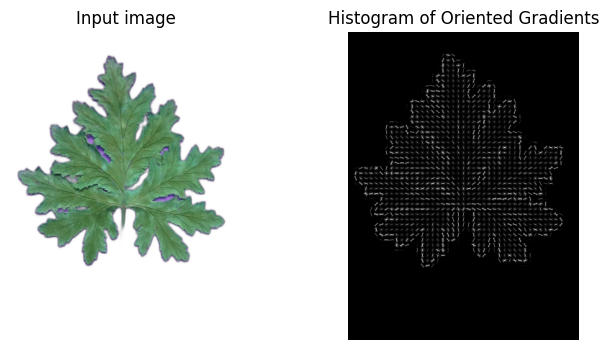

In [61]:
plot_hog_example(images.rgb_images[336])

#### kmean cluster

In [91]:
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(images.list_images_hog)
clusters

c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 2,
       0, 1, 1, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 0, 1,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 2, 1, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0,

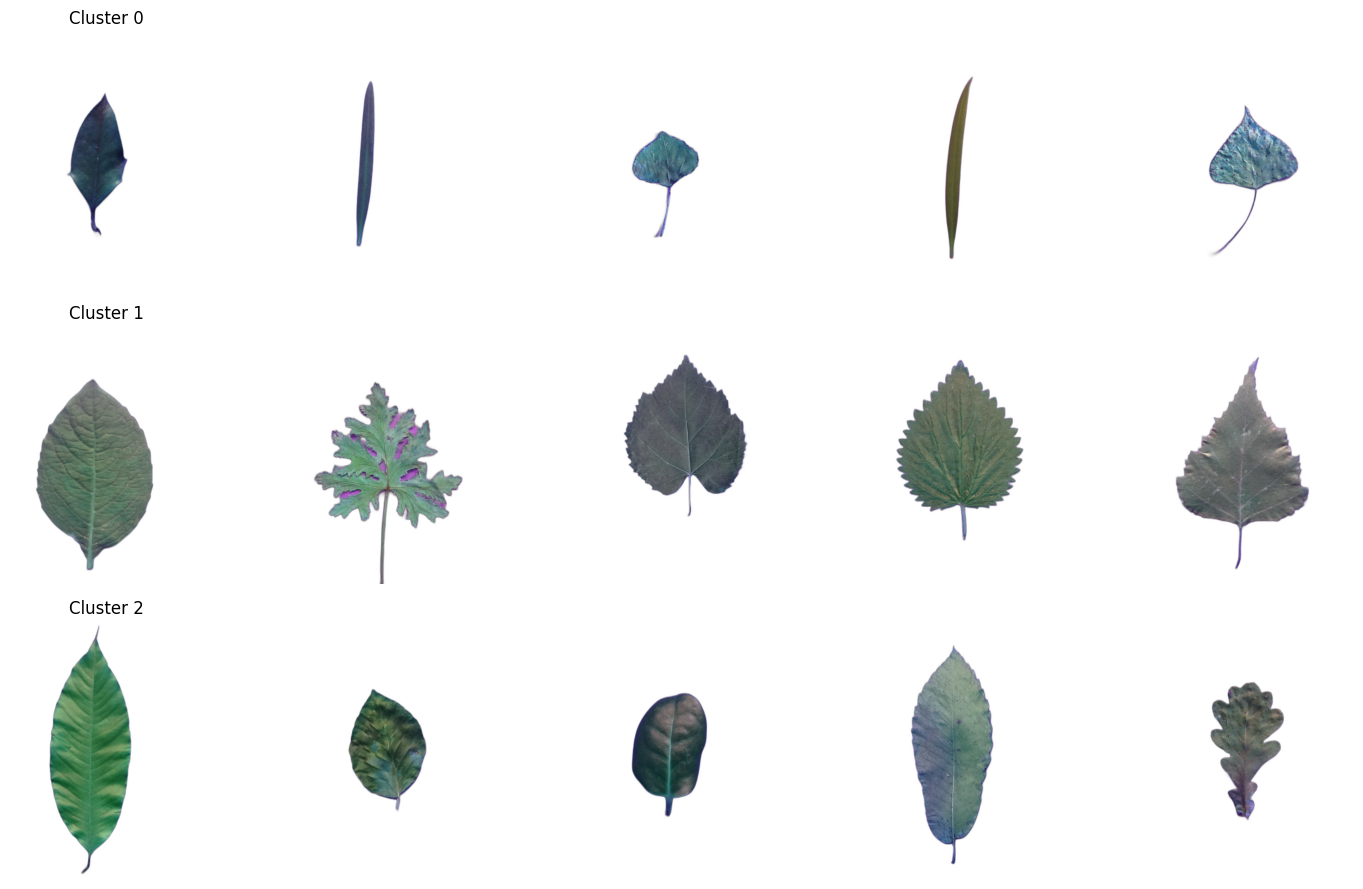

In [92]:
plot_five_ex_clusters(clusters , images.rgb_images)

#### apply PCA on pictures hog

In [10]:
pca_df = apply_pca(images.list_images_hog , 'pictures_hog' , n_components=210)
pca_df

,PC_pictures_hog_1,PC_pictures_hog_2,PC_pictures_hog_3,PC_pictures_hog_4,PC_pictures_hog_5,PC_pictures_hog_6,PC_pictures_hog_7,PC_pictures_hog_8,PC_pictures_hog_9,PC_pictures_hog_10,...,PC_pictures_hog_201,PC_pictures_hog_202,PC_pictures_hog_203,PC_pictures_hog_204,PC_pictures_hog_205,PC_pictures_hog_206,PC_pictures_hog_207,PC_pictures_hog_208,PC_pictures_hog_209,PC_pictures_hog_210
0,-0.594119,11.957643,1.850141,1.296449,-0.628240,-0.272736,-0.939545,-0.881304,0.825068,3.502709,...,-0.196396,-0.347947,-0.978945,-0.183969,-0.076738,-0.454570,-0.365897,-0.295261,0.211654,-1.062218
1,-5.462840,6.630551,1.398753,2.032520,-2.489864,-2.614527,1.289319,-2.431743,1.032352,1.307424,...,-0.211726,0.339984,-0.901266,0.403422,-0.101711,-0.471520,-0.135374,0.012488,-0.098619,0.373503
2,-8.045611,3.459397,1.844997,1.739815,-1.337629,-2.885732,2.867002,-1.077473,2.234836,1.702856,...,0.327712,-0.367169,-0.258805,0.456739,0.511627,0.501751,0.488027,0.346070,-0.013867,0.685308
3,-6.813601,4.748391,-0.922944,-1.251534,-1.517426,-4.275119,-0.412443,-1.199313,1.102451,-1.004280,...,0.461812,0.679164,0.137529,0.651318,-0.558061,-0.234287,-0.108284,0.145535,0.158178,0.036478
4,-9.762819,2.426339,0.902308,-0.859448,0.557055,-3.604758,-0.683796,0.378261,1.358874,1.373057,...,-0.079783,-0.354274,0.242383,-0.144884,0.074533,-0.080777,-0.013647,-0.486161,-0.241976,-0.129519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,12.018704,2.145812,6.078847,-2.208265,3.163245,-0.992058,-0.434896,0.961212,2.392362,-2.863476,...,0.042773,0.017374,-0.051666,0.178663,-0.136338,0.120235,-0.140156,0.089016,0.036769,0.004108
336,14.362893,3.853690,8.982595,-0.632179,4.777527,0.280873,-3.447450,3.208141,3.494227,-0.054845,...,0.012490,0.011463,0.043451,0.027259,0.130624,-0.082435,0.145619,-0.021146,0.174617,-0.168521
337,7.886197,1.708205,8.237058,2.659977,-1.900034,-0.628896,-3.510577,-0.657401,-3.211343,-1.105304,...,0.219858,-0.098051,0.277032,0.049543,-0.132684,-0.128277,-0.075710,0.166579,0.059628,0.094455
338,0.592375,-5.476901,6.287895,-2.251541,0.299909,-4.065912,-0.193817,-0.358722,1.842810,-2.262676,...,0.307035,-0.274068,-0.227034,-0.304960,0.063061,-0.362998,0.203523,0.086767,-0.091375,0.096298


In [11]:
# calculate mean of each hog
list_hog = []
for hog in images.list_images_hog:
    list_hog.append(hog.mean())

In [12]:
# new_df = pd.read_csv('new_leaves.csv').drop(['Unnamed: 0'],axis=1)
new_features['hog_Kmeans_2_cluster']= clusters
new_features['mean_hog'] = list_hog
new_features = pd.concat([new_features , pca_df ], axis=1)
new_features

,mean_distance,std_distance,min_distance,legth_to_width_ratio,avg_leaf_to_background_ratio,num_petals_of_leaves,Perimeter,Convexity,Form_Factor,red_mean_color,...,PC_pictures_hog_201,PC_pictures_hog_202,PC_pictures_hog_203,PC_pictures_hog_204,PC_pictures_hog_205,PC_pictures_hog_206,PC_pictures_hog_207,PC_pictures_hog_208,PC_pictures_hog_209,PC_pictures_hog_210
0,0.703678,0.111736,0.542103,1.631579,2.244901,2,1324.923002,1.122935,0.654050,137.874492,...,-0.196396,-0.347947,-0.978945,-0.183969,-0.076738,-0.454570,-0.365897,-0.295261,0.211654,-1.062218
1,0.704189,0.107399,0.543525,1.654028,2.066886,2,954.205187,1.104718,0.679600,135.351634,...,-0.211726,0.339984,-0.901266,0.403422,-0.101711,-0.471520,-0.135374,0.012488,-0.098619,0.373503
2,0.636708,0.138305,0.465885,1.809816,1.882448,3,779.251868,1.086929,0.643277,129.790995,...,0.327712,-0.367169,-0.258805,0.456739,0.511627,0.501751,0.488027,0.346070,-0.013867,0.685308
3,0.646394,0.119500,0.469862,1.634518,1.938800,2,897.920916,1.106151,0.646818,124.600246,...,0.461812,0.679164,0.137529,0.651318,-0.558061,-0.234287,-0.108284,0.145535,0.158178,0.036478
4,0.627335,0.154731,0.407736,2.000000,1.946505,2,693.269115,1.082260,0.612968,123.963884,...,-0.079783,-0.354274,0.242383,-0.144884,0.074533,-0.080777,-0.013647,-0.486161,-0.241976,-0.129519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.666967,0.147156,0.292140,1.010050,0.956037,11,3844.945639,2.064982,0.149846,178.925034,...,0.042773,0.017374,-0.051666,0.178663,-0.136338,0.120235,-0.140156,0.089016,0.036769,0.004108
336,0.685826,0.135519,0.296964,1.013953,1.088619,16,4631.954859,2.293630,0.128529,170.040649,...,0.012490,0.011463,0.043451,0.027259,0.130624,-0.082435,0.145619,-0.021146,0.174617,-0.168521
337,0.430635,0.128816,0.190799,1.580460,0.501203,13,3931.173991,1.962504,0.116930,203.234973,...,0.219858,-0.098051,0.277032,0.049543,-0.132684,-0.128277,-0.075710,0.166579,0.059628,0.094455
338,0.591605,0.204739,0.159810,2.048969,0.406573,7,2848.924214,2.045761,0.135524,200.613402,...,0.307035,-0.274068,-0.227034,-0.304960,0.063061,-0.362998,0.203523,0.086767,-0.091375,0.096298


In [104]:
# new_df.to_csv('new_leaves.csv')

### cluster and apply PCA on dectances

In [15]:
images.Calculate_distance_each_contour_from_centroid()
len(images.list_distances)

340

In [16]:
# find max len destances 
max_len=0
for destance in images.list_distances: 
    if len(destance)> max_len:
        max_len = len(destance)

# convert all distances to the same shape (Fill smaller lists with zero)
padded_list = [sublist + [0] * (max_len - len(sublist)) for sublist in images.list_distances]
padded_list = np.array(padded_list)
padded_list.shape

(340, 1984)

#### kmean cluster

In [50]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(padded_list)
clusters

c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([6, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 6, 2, 2, 2, 1,
       4, 2, 1, 6, 4, 2, 6, 2, 1, 6, 1, 2, 1, 6, 2, 2, 2, 1, 1, 1, 1, 4,
       4, 4, 1, 4, 4, 1, 4, 4, 6, 6, 4, 1, 1, 4, 4, 0, 1, 6, 4, 6, 6, 1,
       1, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 6, 3, 1, 1, 1,
       0, 4, 4, 6, 1, 2, 1, 3, 3, 1, 4, 3, 3, 6, 1, 1, 3, 1, 1, 3, 4, 3,
       3, 3, 4, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 1, 4, 1, 1, 6, 2, 3,
       4, 4, 4, 1, 6, 6, 6, 0, 6, 1, 2, 1, 6, 6, 6, 4, 6, 1, 4, 4, 1, 6,
       4, 2, 1, 1, 1, 4, 1, 3, 5, 5, 5, 1, 3, 5, 3, 5, 5, 2, 2, 2, 2, 1,
       6, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 6, 2, 2, 0, 6, 2, 0, 6, 2, 2, 6,
       2, 1, 2, 0, 6, 6, 6, 2, 0, 4, 4, 1, 4, 1, 3, 1, 6, 3, 2, 2, 2, 2,
       2, 2, 6, 0, 6, 2, 6, 2, 2, 2, 2, 2, 2, 2, 6, 2, 6, 6, 0, 4, 6, 4,
       6, 4, 4, 4, 6, 4, 1, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 3, 1, 3, 1, 1, 6, 3, 1, 4, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0,
       2, 2, 6, 2, 2, 2, 2, 2, 2, 0, 0, 6, 1, 6, 0,

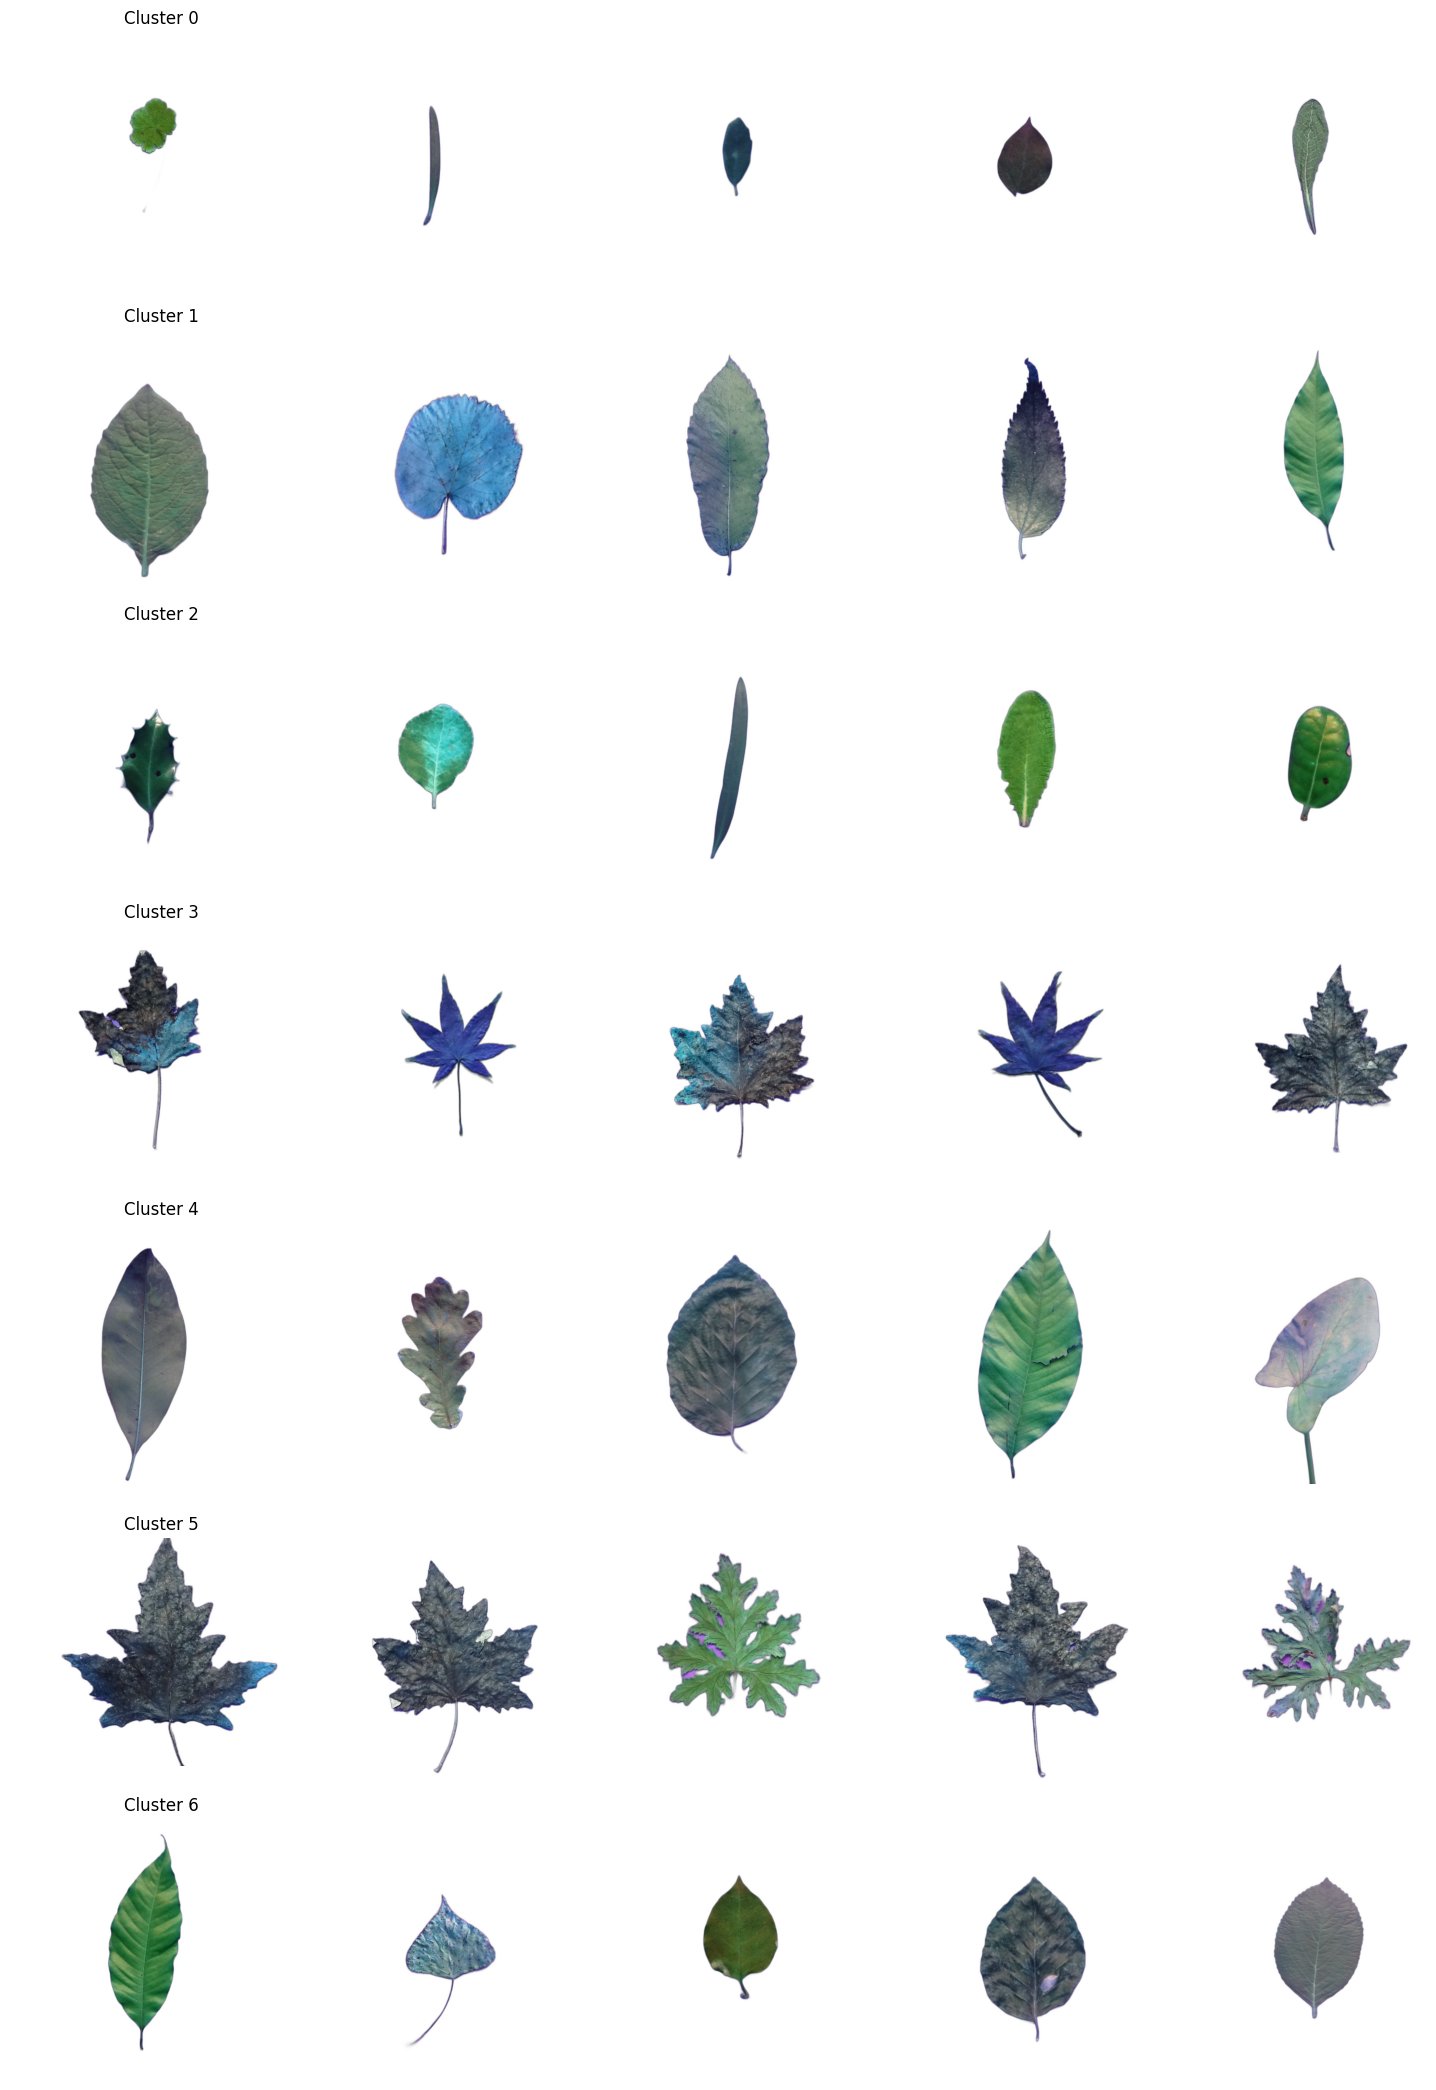

In [51]:
plot_five_ex_clusters(clusters , images.rgb_images)

#### apply PCA

In [17]:
pca_df = apply_pca(padded_list , "dectances_from_centroid" , n_components=100)
pca_df

,PC_dectances_from_centroid_1,PC_dectances_from_centroid_2,PC_dectances_from_centroid_3,PC_dectances_from_centroid_4,PC_dectances_from_centroid_5,PC_dectances_from_centroid_6,PC_dectances_from_centroid_7,PC_dectances_from_centroid_8,PC_dectances_from_centroid_9,PC_dectances_from_centroid_10,...,PC_dectances_from_centroid_91,PC_dectances_from_centroid_92,PC_dectances_from_centroid_93,PC_dectances_from_centroid_94,PC_dectances_from_centroid_95,PC_dectances_from_centroid_96,PC_dectances_from_centroid_97,PC_dectances_from_centroid_98,PC_dectances_from_centroid_99,PC_dectances_from_centroid_100
0,-1.140975,-3.884069,2.638508,-0.794175,-2.325441,-0.011948,1.714222,0.368133,-0.857493,1.676416,...,0.067796,0.030246,-0.045624,0.097727,-0.086954,-0.030813,0.011754,0.025224,0.017381,-0.044555
1,-6.435096,0.550471,1.729185,1.047486,1.178520,-1.944458,-0.175574,1.834640,-0.878491,-0.332365,...,-0.401534,-0.253940,-0.343710,-0.221159,0.188085,-0.168028,0.147796,-0.145659,-0.029965,0.102781
2,-7.907891,4.008734,-1.043999,0.520698,-0.190047,-1.030023,1.267858,-0.909390,-0.133605,0.271594,...,0.171398,0.251356,-0.029607,0.109192,-0.303046,-0.049293,0.106762,-0.092711,0.120211,0.088014
3,-6.613881,0.746459,1.522942,0.483941,0.831684,-1.424399,-0.890740,0.697020,-0.673531,0.234644,...,0.052416,-0.022100,-0.030597,-0.105978,0.061453,0.045234,0.067866,-0.043882,-0.094782,0.043910
4,-7.859157,4.059017,-1.273977,0.589789,-0.196111,-0.859955,1.355159,-0.706846,-0.097907,0.555848,...,0.112601,0.208869,-0.062459,0.115548,-0.255823,-0.079985,0.127125,-0.082998,0.098757,0.085537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,11.588817,9.259357,8.527640,-2.206767,0.581945,1.310127,1.450713,2.443147,0.941491,0.629923,...,0.051718,-0.010394,0.018438,0.019767,-0.040500,0.060505,-0.006268,-0.000144,-0.069714,-0.031110
336,12.977147,9.204629,10.938512,0.990760,4.989312,7.568393,6.574174,-0.862730,2.148460,-2.440243,...,-0.008275,0.014367,-0.021301,-0.008905,0.023371,0.019514,-0.001891,0.003620,0.000615,-0.007894
337,5.666209,6.460358,1.656584,1.823129,-1.313776,2.878123,-0.515807,0.988681,0.193932,1.634392,...,0.167616,0.061247,0.147771,0.020413,0.241680,-0.185880,0.078416,-0.313934,-0.110156,0.156194
338,9.511234,5.380538,0.385814,-1.131343,-1.281434,0.629050,1.265826,1.816895,-2.200762,-0.314148,...,-0.049694,-0.048012,-0.012020,-0.006046,0.017687,0.110574,0.144694,-0.091219,-0.226222,0.033419


In [18]:
# new_df = pd.read_csv('new_leaves.csv').drop(['Unnamed: 0'],axis=1)
# new_features['cluster_on_distances']= clusters
new_features = pd.concat([new_features , pca_df], axis=1)
new_features

,mean_distance,std_distance,min_distance,legth_to_width_ratio,avg_leaf_to_background_ratio,num_petals_of_leaves,Perimeter,Convexity,Form_Factor,red_mean_color,...,PC_dectances_from_centroid_91,PC_dectances_from_centroid_92,PC_dectances_from_centroid_93,PC_dectances_from_centroid_94,PC_dectances_from_centroid_95,PC_dectances_from_centroid_96,PC_dectances_from_centroid_97,PC_dectances_from_centroid_98,PC_dectances_from_centroid_99,PC_dectances_from_centroid_100
0,0.703678,0.111736,0.542103,1.631579,2.244901,2,1324.923002,1.122935,0.654050,137.874492,...,0.067796,0.030246,-0.045624,0.097727,-0.086954,-0.030813,0.011754,0.025224,0.017381,-0.044555
1,0.704189,0.107399,0.543525,1.654028,2.066886,2,954.205187,1.104718,0.679600,135.351634,...,-0.401534,-0.253940,-0.343710,-0.221159,0.188085,-0.168028,0.147796,-0.145659,-0.029965,0.102781
2,0.636708,0.138305,0.465885,1.809816,1.882448,3,779.251868,1.086929,0.643277,129.790995,...,0.171398,0.251356,-0.029607,0.109192,-0.303046,-0.049293,0.106762,-0.092711,0.120211,0.088014
3,0.646394,0.119500,0.469862,1.634518,1.938800,2,897.920916,1.106151,0.646818,124.600246,...,0.052416,-0.022100,-0.030597,-0.105978,0.061453,0.045234,0.067866,-0.043882,-0.094782,0.043910
4,0.627335,0.154731,0.407736,2.000000,1.946505,2,693.269115,1.082260,0.612968,123.963884,...,0.112601,0.208869,-0.062459,0.115548,-0.255823,-0.079985,0.127125,-0.082998,0.098757,0.085537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.666967,0.147156,0.292140,1.010050,0.956037,11,3844.945639,2.064982,0.149846,178.925034,...,0.051718,-0.010394,0.018438,0.019767,-0.040500,0.060505,-0.006268,-0.000144,-0.069714,-0.031110
336,0.685826,0.135519,0.296964,1.013953,1.088619,16,4631.954859,2.293630,0.128529,170.040649,...,-0.008275,0.014367,-0.021301,-0.008905,0.023371,0.019514,-0.001891,0.003620,0.000615,-0.007894
337,0.430635,0.128816,0.190799,1.580460,0.501203,13,3931.173991,1.962504,0.116930,203.234973,...,0.167616,0.061247,0.147771,0.020413,0.241680,-0.185880,0.078416,-0.313934,-0.110156,0.156194
338,0.591605,0.204739,0.159810,2.048969,0.406573,7,2848.924214,2.045761,0.135524,200.613402,...,-0.049694,-0.048012,-0.012020,-0.006046,0.017687,0.110574,0.144694,-0.091219,-0.226222,0.033419


In [19]:
df = pd.read_csv('leaves.csv', header=None)
df.columns = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
df

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,0.114880,0.208610,0.041703,0.013344,0.000820,2.02810
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,0.141220,0.218300,0.045488,0.012002,0.001515,2.40590
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,0.097663,0.207030,0.041101,0.016123,0.000453,1.69350
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,0.050389,0.135850,0.018121,0.006190,0.000265,1.15260


In [20]:
new_features = pd.concat([df , new_features], axis=1)
new_features

,A,B,C,D,E,F,G,H,I,J,...,PC_dectances_from_centroid_91,PC_dectances_from_centroid_92,PC_dectances_from_centroid_93,PC_dectances_from_centroid_94,PC_dectances_from_centroid_95,PC_dectances_from_centroid_96,PC_dectances_from_centroid_97,PC_dectances_from_centroid_98,PC_dectances_from_centroid_99,PC_dectances_from_centroid_100
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,...,0.067796,0.030246,-0.045624,0.097727,-0.086954,-0.030813,0.011754,0.025224,0.017381,-0.044555
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,...,-0.401534,-0.253940,-0.343710,-0.221159,0.188085,-0.168028,0.147796,-0.145659,-0.029965,0.102781
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,...,0.171398,0.251356,-0.029607,0.109192,-0.303046,-0.049293,0.106762,-0.092711,0.120211,0.088014
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,...,0.052416,-0.022100,-0.030597,-0.105978,0.061453,0.045234,0.067866,-0.043882,-0.094782,0.043910
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,...,0.112601,0.208869,-0.062459,0.115548,-0.255823,-0.079985,0.127125,-0.082998,0.098757,0.085537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,...,0.051718,-0.010394,0.018438,0.019767,-0.040500,0.060505,-0.006268,-0.000144,-0.069714,-0.031110
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,...,-0.008275,0.014367,-0.021301,-0.008905,0.023371,0.019514,-0.001891,0.003620,0.000615,-0.007894
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,...,0.167616,0.061247,0.147771,0.020413,0.241680,-0.185880,0.078416,-0.313934,-0.110156,0.156194
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,...,-0.049694,-0.048012,-0.012020,-0.006046,0.017687,0.110574,0.144694,-0.091219,-0.226222,0.033419


In [21]:
new_features.to_csv('final_features.csv')

In [31]:
plot_images = Images_class() # creat an object
plot_images.get_images_inf('disentces_plot/') # get images and there informations

c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
